### Geomorphology Assignment
Group Members:
1) Sahil Yadav *(23110287)*
2) Pawar Tamanna Sureshbhai *(21110157)*
3) Akhil. P *(24310006)*
4) Chavda Haarit Ravindrakumar *(23110077)*

In [13]:
import numpy as np
from matplotlib import pyplot as plt

from landlab import RasterModelGrid, imshow_grid
from landlab.components import (
    ChannelProfiler,
    ChiFinder,
    FlowAccumulator,
    SteepnessFinder,
    StreamPowerEroder,
    LinearDiffuser,
)
from landlab.io import write_esri_ascii


def wrapper(
    K_sp=1e-5,
    D=0.5,
    m_sp=0.5,
    n_sp=1,
    number_of_rows=120,
    number_of_columns=120,
    dxy=100,
    tmax=1e6,
    dt=1000,
    uplift_rate_value=1e-4,
    random_seed=56,
):
 
    # Create grid
    mg = RasterModelGrid((number_of_rows, number_of_columns), dxy)

    # Initialize elevation with random noise
    np.random.seed(random_seed)
    noise = np.random.rand(mg.number_of_nodes) / 1000.0
    z = mg.add_zeros("topographic__elevation", at="node")
    z += noise

    # Boundary conditions: south side open
    mg.set_watershed_boundary_condition("topographic__elevation")

    # Time setup
    total_time = 0.0
    time_steps = np.arange(0, tmax, dt)

    # Stream power and hillslope components
    frr = FlowAccumulator(mg, flow_director='FlowDirectorD8')
    spr = StreamPowerEroder(mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0.0)
    ld = LinearDiffuser(mg, linear_diffusivity=D, deposit=False)

    theta = m_sp / n_sp
    sf = SteepnessFinder(mg, reference_concavity=theta, min_drainage_area=1000.0)
    cf = ChiFinder(mg, min_drainage_area=1000.0, reference_concavity=theta, use_true_dx=True)

    # Uplift rate field
    uplift_rate = np.ones(mg.number_of_nodes) * uplift_rate_value

    # Evolution loop
    for _ in time_steps:
        # Uplift
        z[mg.core_nodes] += uplift_rate[mg.core_nodes] * dt
        # Hillslope diffusion
        ld.run_one_step(dt)
        # Flow routing
        frr.run_one_step()
        # Fluvial incision
        spr.run_one_step(dt)
        total_time += dt

    # Plotting results
    # Elevation map
    imshow_grid(
        mg,
        "topographic__elevation",
        grid_units=("m", "m"),
        var_name="Elevation (m)",
    )
    plt.title(f"$K_{{sp}}$={K_sp}; $D$={D}; $time$={int(total_time)} yr; $dx$={dxy} m")
    plt.show()

    # Steepest slope map
    imshow_grid(
        mg,
        "topographic__steepest_slope",
        grid_units=("m", "m"),
        var_name="Slope (m/m)",
    )
    plt.title(f"$K_{{sp}}$={K_sp}; $D$={D}; $time$={int(total_time)} yr; concavity={theta}")
    plt.show()

    # Global slope-area plot
    plt.figure()
    plt.loglog(
        mg.at_node["drainage_area"][mg.core_nodes],
        mg.at_node["topographic__steepest_slope"][mg.core_nodes],
        'b.',
    )
    plt.xlabel("Drainage area (m^2)")
    plt.ylabel("Topographic slope")
    plt.title(f"$K_{{sp}}$={K_sp}; $D$={D}; $time$={int(total_time)} yr")
    plt.show()

    # Channel profiling
    prf = ChannelProfiler(
        mg,
        number_of_watersheds=1,
        main_channel_only=True,
        minimum_channel_threshold=dxy**2,
    )
    prf.run_one_step()

    # Profile plot
    prf.plot_profiles(
        xlabel='Distance upstream (m)',
        ylabel='Elevation (m)',
        title=f"Profile: $K_{{sp}}$={K_sp}, $D$={D}, time={int(total_time)} yr"
    )
    plt.show()


    # critical_drainage_area = cf.crit
    mean_slope = np.mean(mg.at_node["topographic__steepest_slope"][mg.core_nodes])
    total_relief = np.max(z) - np.min(z)
    channel_steepness = np.mean(mg.at_node["channel__steepness_index"][mg.core_nodes])

    print(f"Diffusivity used: {D} m²/yr")
    # print(f"Critical drainage area (approx): {critical_drainage_area} m²")
    print(f"Average slope: {mean_slope:.4f}")
    print(f"Total relief: {total_relief:.2f} m")
    print(f"Mean channel steepness index: {channel_steepness:.2f}")


    np.seterr(divide='ignore')
    outlet_id = next(iter(prf.data_structure))
    segment_id = next(iter(prf.data_structure[outlet_id]))
    profile_ids = prf.data_structure[outlet_id][segment_id]['ids']
    a = mg.at_node["drainage_area"][profile_ids]
    s = mg.at_node["topographic__steepest_slope"][profile_ids]

    max_point_s = max(np.log(s))
    index = np.where(np.log(s) == max_point_s)[0]
    critical_a = np.log(a)[index]
    print(f"Critical drainage area is {round(np.exp(critical_a[0]),6)} m2")

    plt.scatter(np.log(a),np.log(s),linewidth=0.1)
    plt.plot(np.log(a),np.log(s),linewidth=0.5,color='red')
    plt.axvline(x=critical_a, color='gray', linestyle='--', linewidth=1,label="log(Critical Drainage area)")
    plt.xlabel("log(Drainage area)")
    plt.ylabel("log(Topographic slope)")
    plt.legend()
    plt.show()


    return mg, prf


1. Using the parameters provided in the initial notebook, run the landscape to steady state. (Note that you can keep running the main evolution loop - Code Block 7 - and the different plotting blocks without running the code blocks above them.) [These landscapes may not reach a perfect steady state. Close is fine.] When the landscape reaches steady state, record the channel steepness, $k_{sn}$, (only applies for the channelized part of the landscape), the average slope of the entire watershed, and the total relief (in this case the minimum elevation is zero, so the total relief is just the maximum elevation). Also note the approximate critical drainage area. (See the description at the top of this notebook if you don't know that term.) Save some illustrative plots. This example has a relatively small critical drainage area/large drainage density. (10 pts)

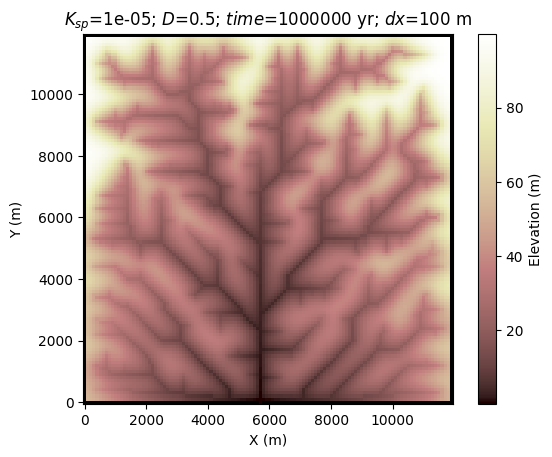

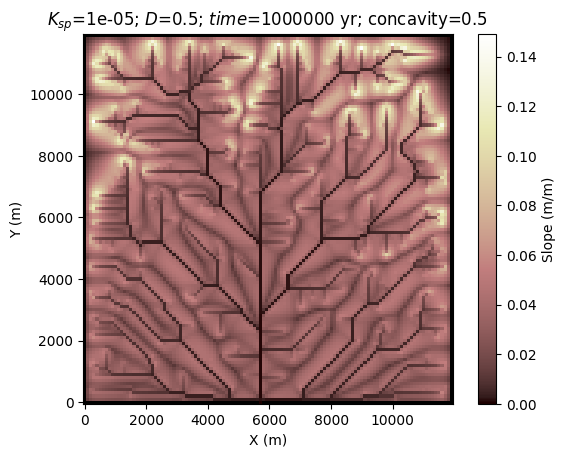

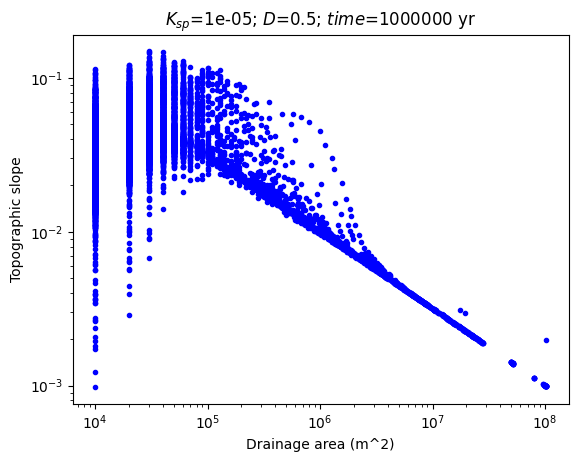

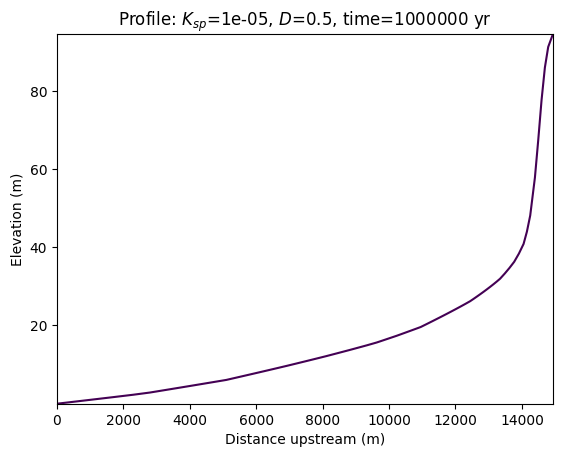

Diffusivity used: 0.5 m²/yr
Average slope: 0.0395
Total relief: 99.84 m
Mean channel steepness index: 0.00
Critical drainage area is 100000.0 m2


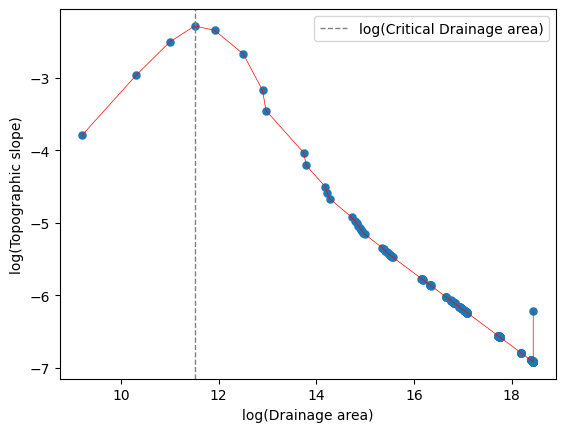

(RasterModelGrid((120, 120), xy_spacing=(np.float64(100.0), np.float64(100.0)), xy_of_lower_left=(np.float64(0.0), np.float64(0.0))),
 <landlab.components.profiler.channel_profiler.ChannelProfiler at 0x20bf4e09b10>)

In [14]:
wrapper()

2. Rerun the notebook with a new diffusivity value, but keep all other parameters the same (so do not change the fluvial erodibility or rock uplift value). You should find a scenario with a critical drainage area higher than the initial value, but less than 1e6 m$^2$. Run to steady state, and record the critical drainage area, channel steepness index, average slope, and total relief. Make sure you also record the diffusivity value used. Save some illustrative plots. (10 pts)

3. Repeat step 2. So same everything except use a third, different diffusivity value. This example should have a different critical drainage from the previous two landscapes, and the critical drainage area should be less than 1e6 m$^2$. (10 pts)

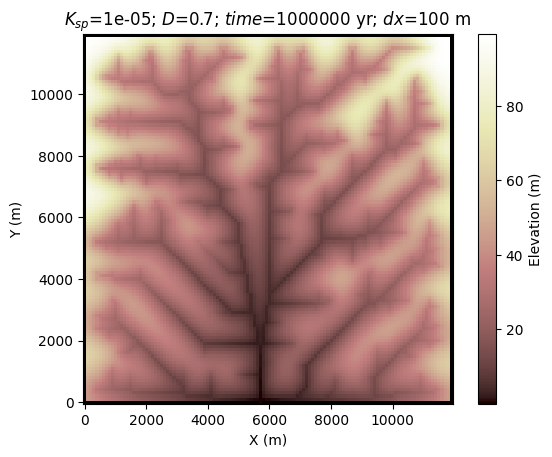

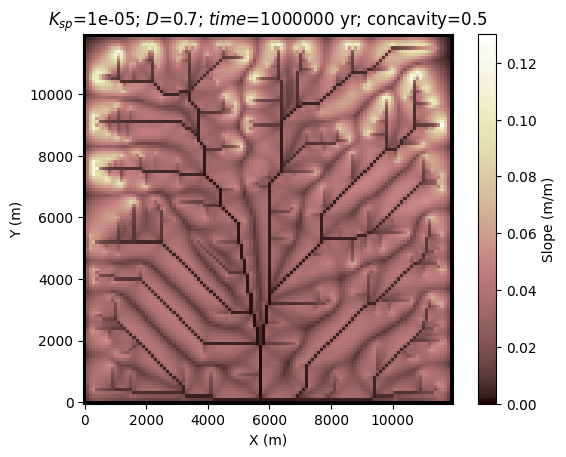

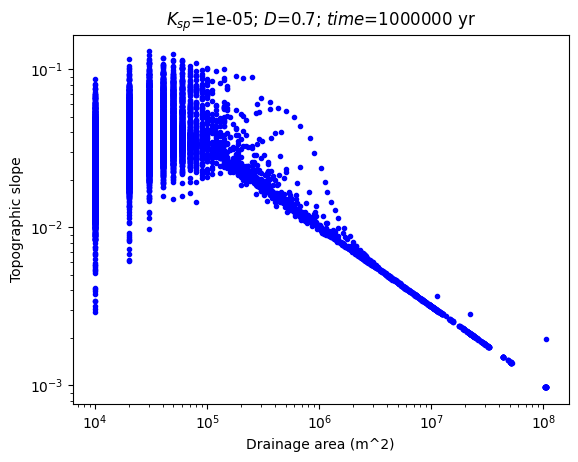

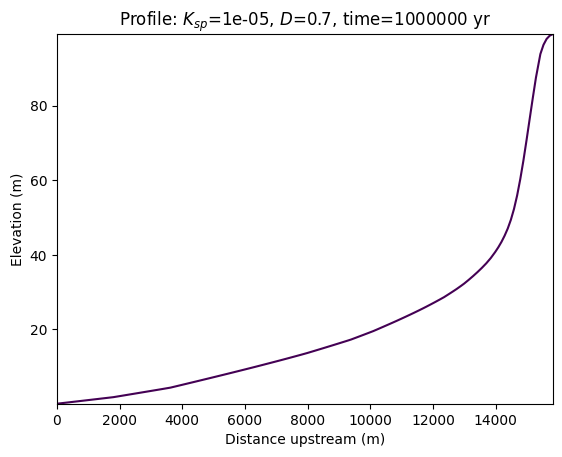

Diffusivity used: 0.7 m²/yr
Average slope: 0.0337
Total relief: 99.25 m
Mean channel steepness index: 0.00
Critical drainage area is 430000.0 m2


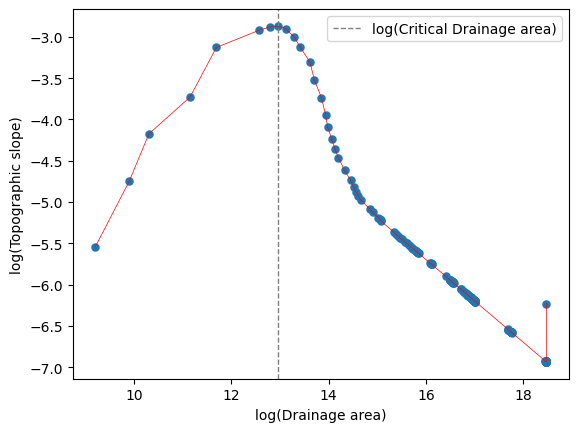

(RasterModelGrid((120, 120), xy_spacing=(np.float64(100.0), np.float64(100.0)), xy_of_lower_left=(np.float64(0.0), np.float64(0.0))),
 <landlab.components.profiler.channel_profiler.ChannelProfiler at 0x20bf4e167a0>)

In [15]:
wrapper(D=0.7)

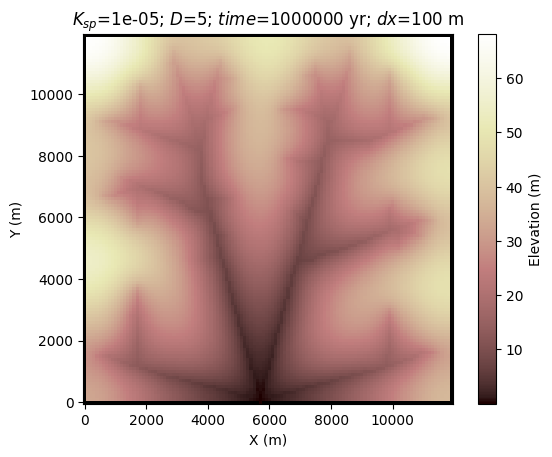

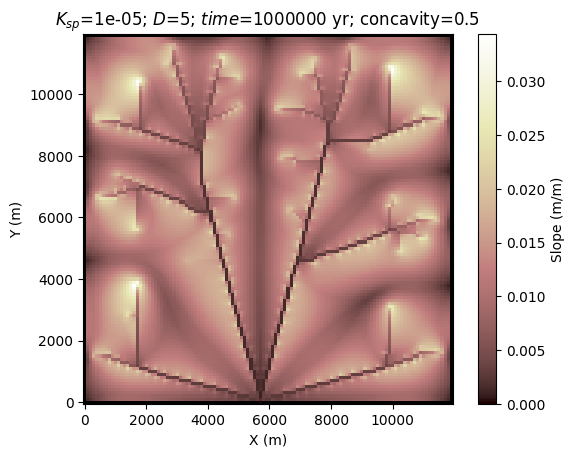

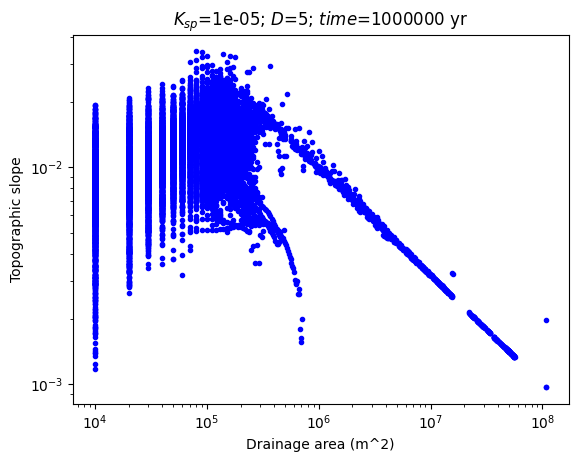

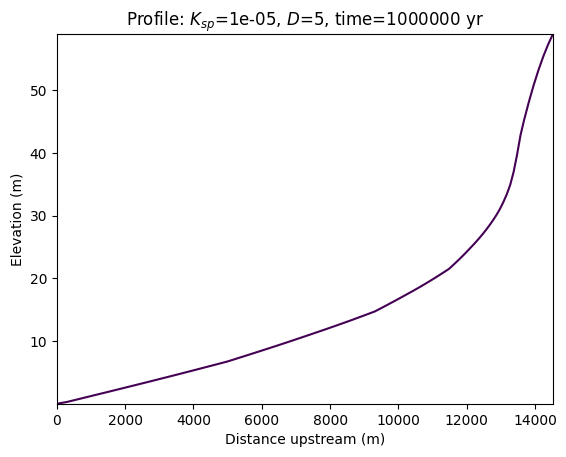

Diffusivity used: 5 m²/yr
Average slope: 0.0117
Total relief: 68.11 m
Mean channel steepness index: 0.00
Critical drainage area is 150000.0 m2


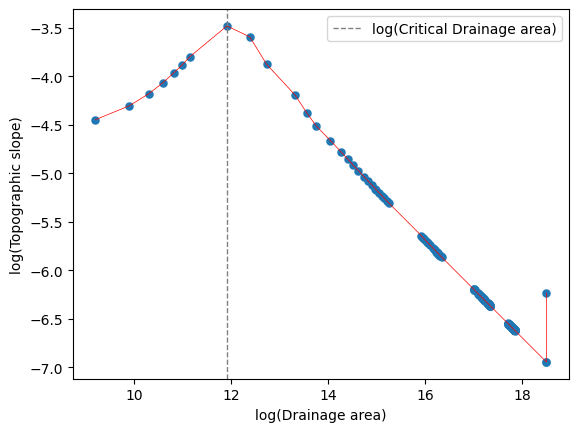

(RasterModelGrid((120, 120), xy_spacing=(np.float64(100.0), np.float64(100.0)), xy_of_lower_left=(np.float64(0.0), np.float64(0.0))),
 <landlab.components.profiler.channel_profiler.ChannelProfiler at 0x20bf658e410>)

In [16]:
wrapper(D=5)

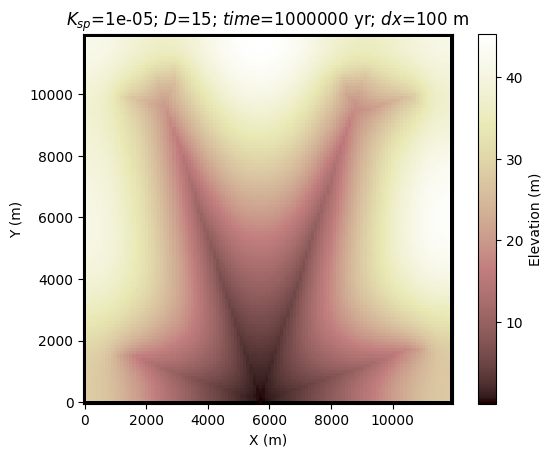

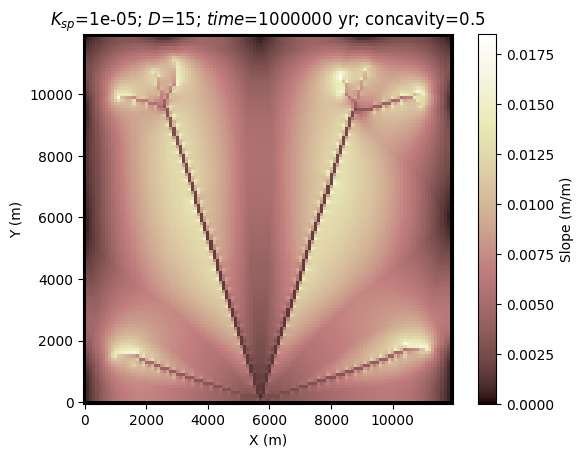

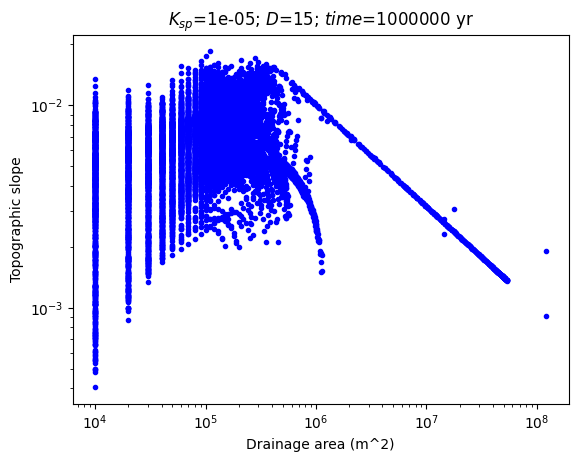

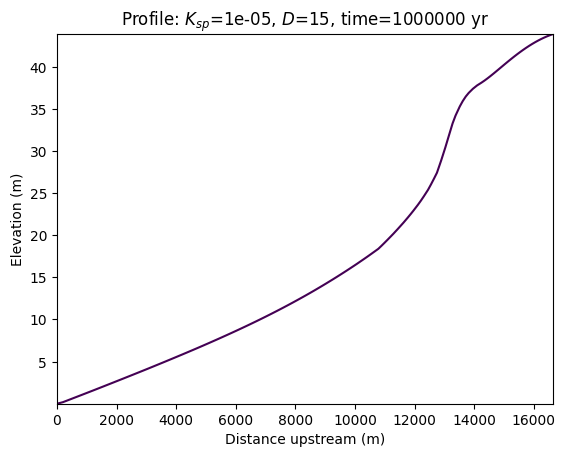

Diffusivity used: 15 m²/yr
Average slope: 0.0073
Total relief: 45.25 m
Mean channel steepness index: 0.00
Critical drainage area is 750000.0 m2


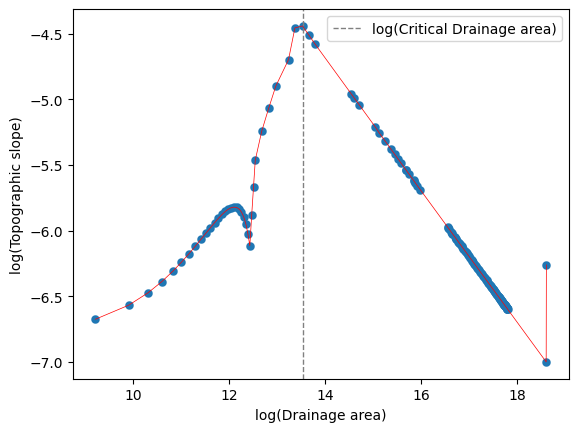

(RasterModelGrid((120, 120), xy_spacing=(np.float64(100.0), np.float64(100.0)), xy_of_lower_left=(np.float64(0.0), np.float64(0.0))),
 <landlab.components.profiler.channel_profiler.ChannelProfiler at 0x20bf53588e0>)

In [17]:
wrapper(D = 15)

4. Now repeat steps 1, 2, and 3, two more times. I want you to choose two different fluvial erodibility values (both should be smaller than the original value of $K_{sp} = 1E-5$, i.e. they should produce larger $k_{sn}$ values). For each $K_{sp}$ value, you should produce three landscapes with three different diffusivity values. Try to keep all slope values (on hillslopes and channels) less than 1 m/m. Try to keep the critical drainage area less than 1e6 m$^2$. Record critical drainage area, channel steepness index, average slope, and total relief for all the landscapes. (20 pts)

| # | K_sp     | D   | Reason          |
|---|----------|-----|-----------------|
| 1 | 1.0e^-6  | 0.1 | Roughest        |
| 2 | 1.0e^-6  | 0.5 | Balanced        |
| 3 | 1.0e^-6  | 1.0 | Lowest slope    |
| 4 | 5.0e^-7  | 1.0 | Flattest result |
| 5 | 5.0e^-7  | 0.5 | Balanced        |
| 6 | 5.0e^-7  | 0.1 | Higher K_sn     |


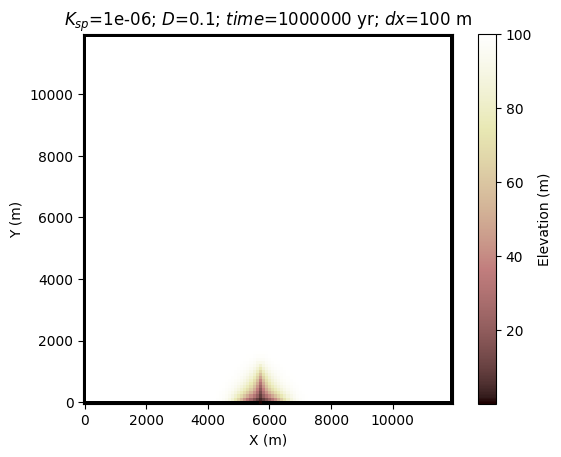

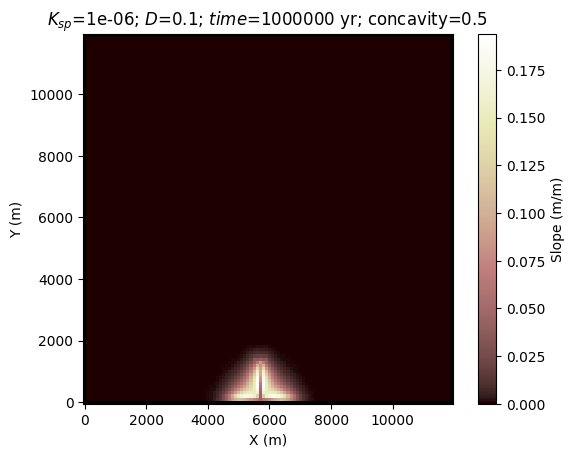

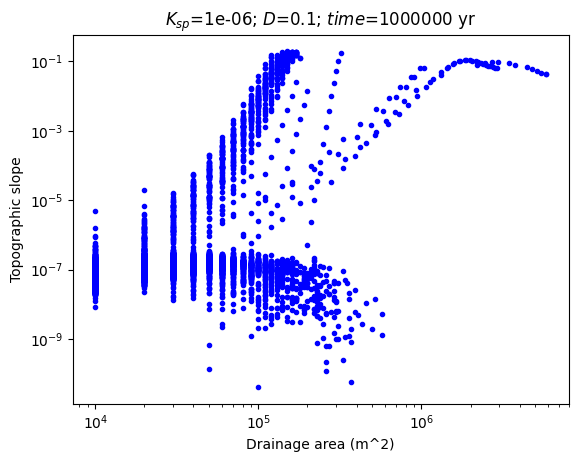

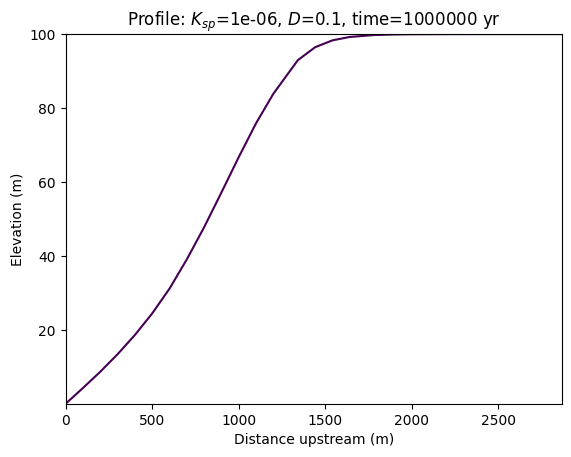

Diffusivity used: 0.1 m²/yr
Average slope: 0.0015
Total relief: 100.00 m
Mean channel steepness index: 0.00
Critical drainage area is 2690000.0 m2


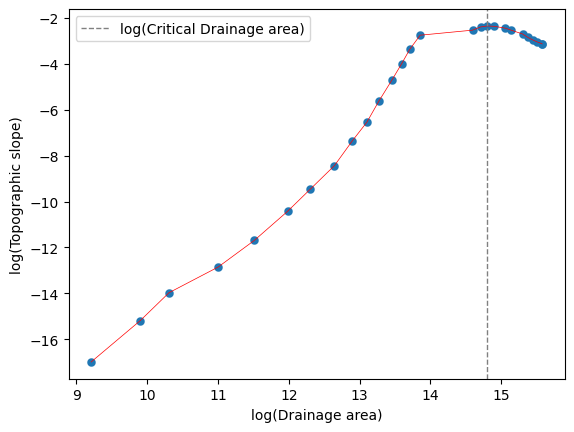

(RasterModelGrid((120, 120), xy_spacing=(np.float64(100.0), np.float64(100.0)), xy_of_lower_left=(np.float64(0.0), np.float64(0.0))),
 <landlab.components.profiler.channel_profiler.ChannelProfiler at 0x20bf353ec20>)

In [18]:
wrapper(K_sp=1e-6,D=0.1)

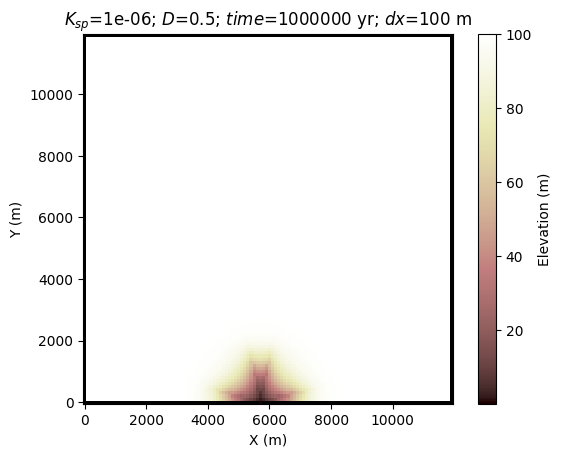

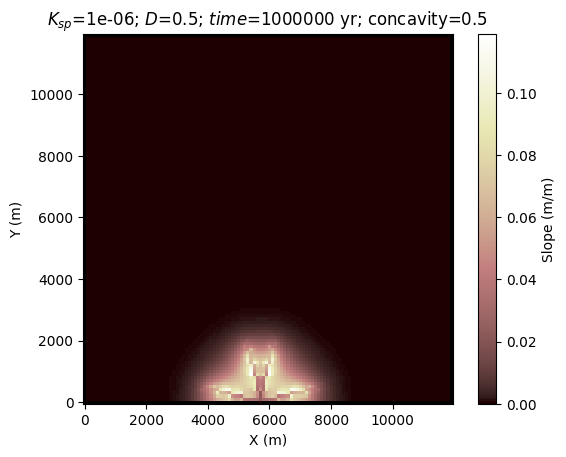

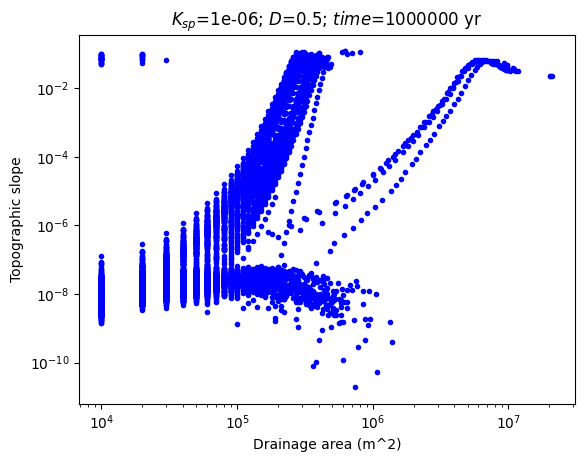

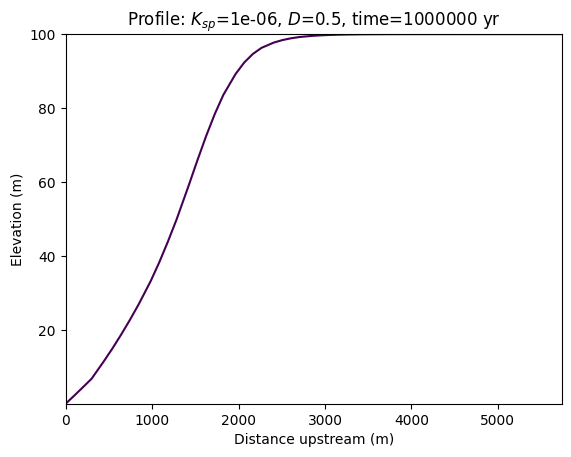

Diffusivity used: 0.5 m²/yr
Average slope: 0.0025
Total relief: 100.00 m
Mean channel steepness index: 0.00
Critical drainage area is 6190000.0 m2


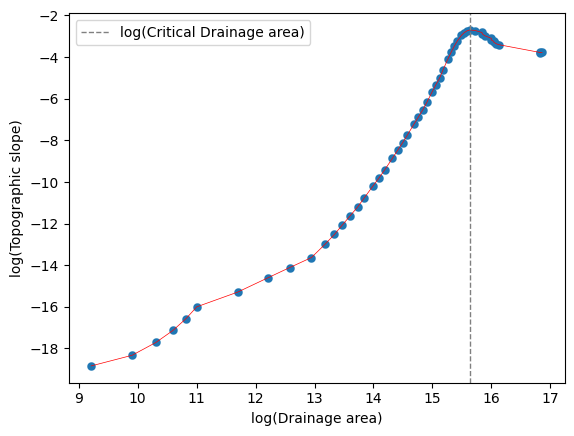

(RasterModelGrid((120, 120), xy_spacing=(np.float64(100.0), np.float64(100.0)), xy_of_lower_left=(np.float64(0.0), np.float64(0.0))),
 <landlab.components.profiler.channel_profiler.ChannelProfiler at 0x20bf3747fa0>)

In [19]:
wrapper(K_sp=1e-6,D=0.5)

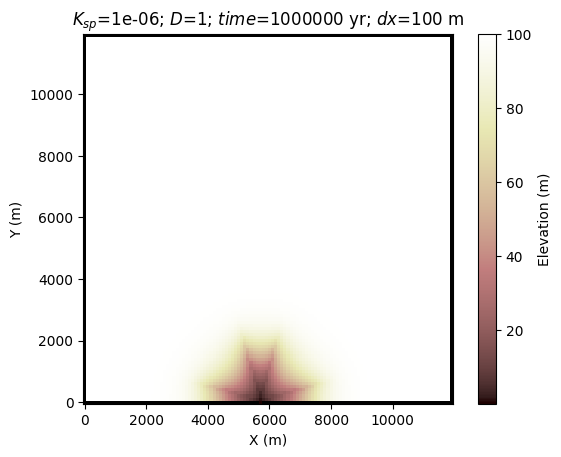

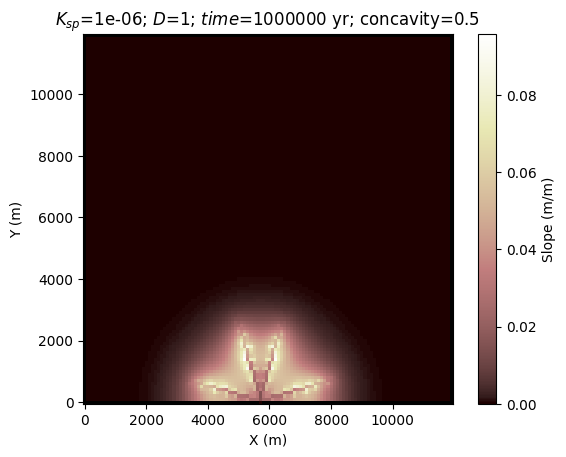

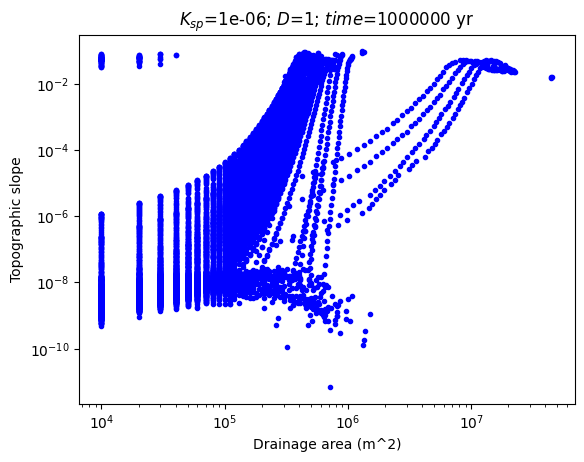

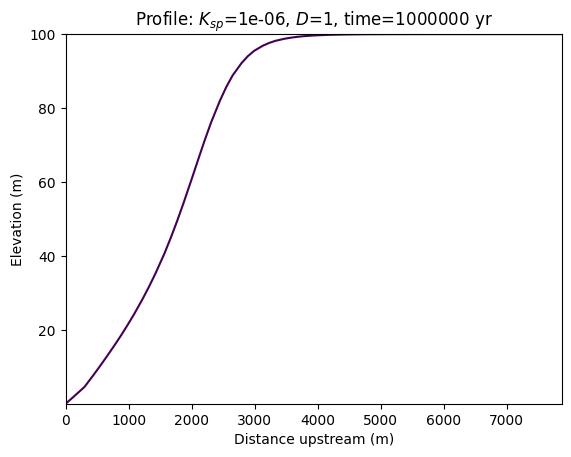

Diffusivity used: 1 m²/yr
Average slope: 0.0034
Total relief: 100.00 m
Mean channel steepness index: 0.00
Critical drainage area is 14480000.0 m2


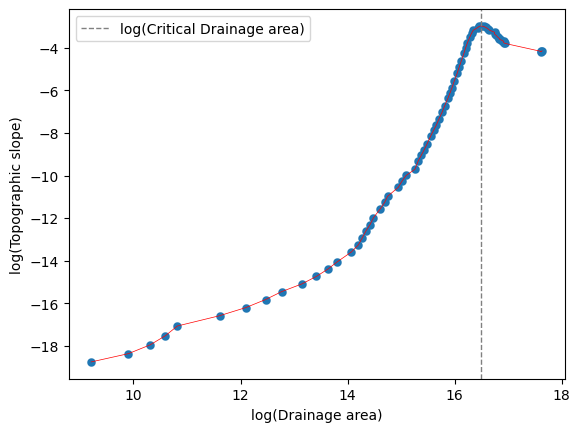

(RasterModelGrid((120, 120), xy_spacing=(np.float64(100.0), np.float64(100.0)), xy_of_lower_left=(np.float64(0.0), np.float64(0.0))),
 <landlab.components.profiler.channel_profiler.ChannelProfiler at 0x20bf364f550>)

In [20]:
wrapper(K_sp=1e-6,D=1)

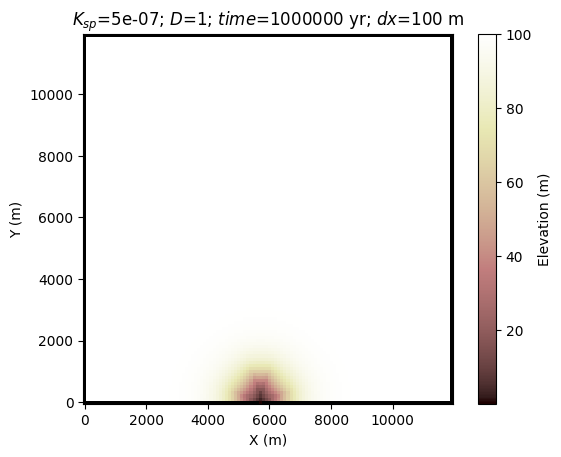

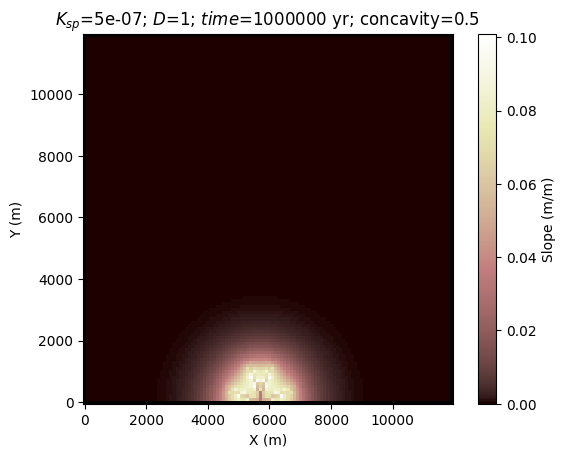

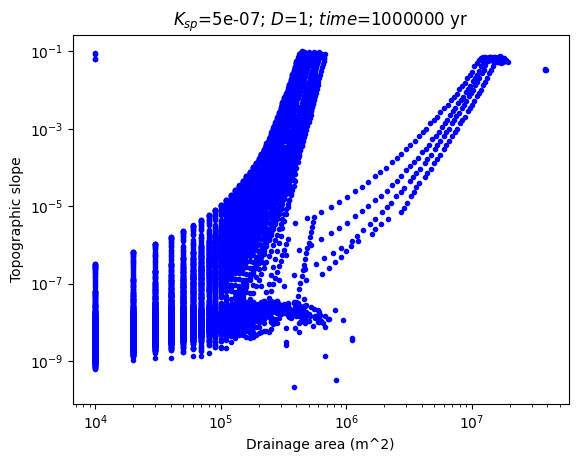

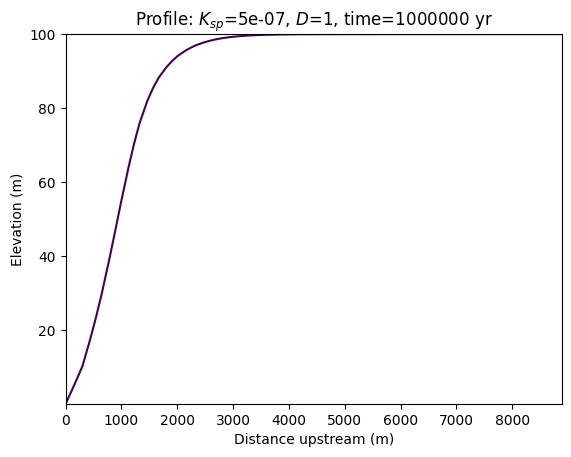

Diffusivity used: 1 m²/yr
Average slope: 0.0020
Total relief: 100.00 m
Mean channel steepness index: 0.00
Critical drainage area is 16650000.0 m2


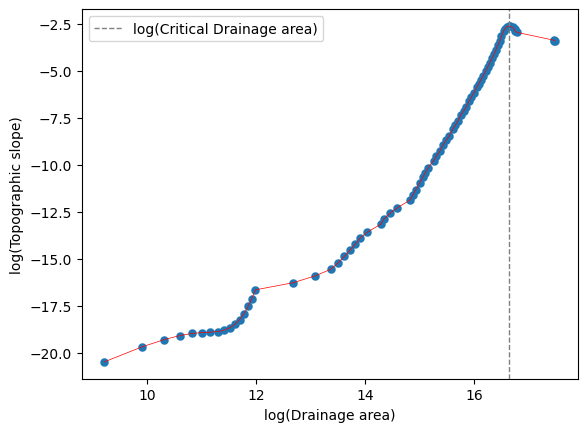

(RasterModelGrid((120, 120), xy_spacing=(np.float64(100.0), np.float64(100.0)), xy_of_lower_left=(np.float64(0.0), np.float64(0.0))),
 <landlab.components.profiler.channel_profiler.ChannelProfiler at 0x20bf364cdc0>)

In [21]:
wrapper(K_sp=5e-7,D=1)

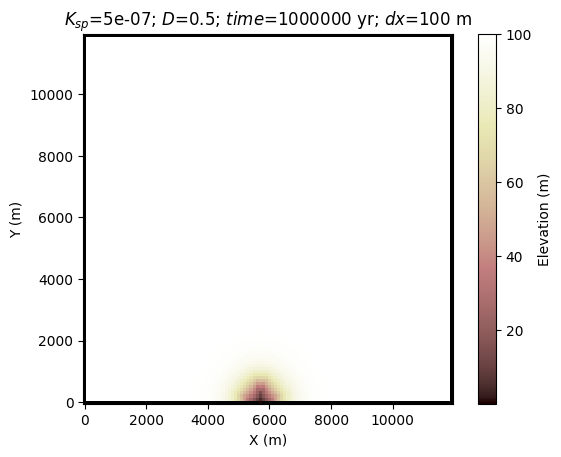

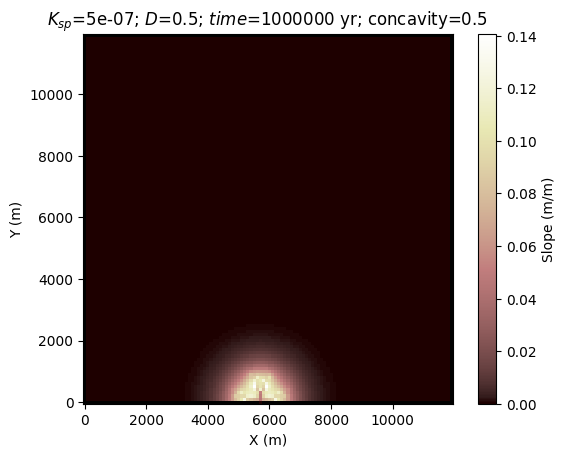

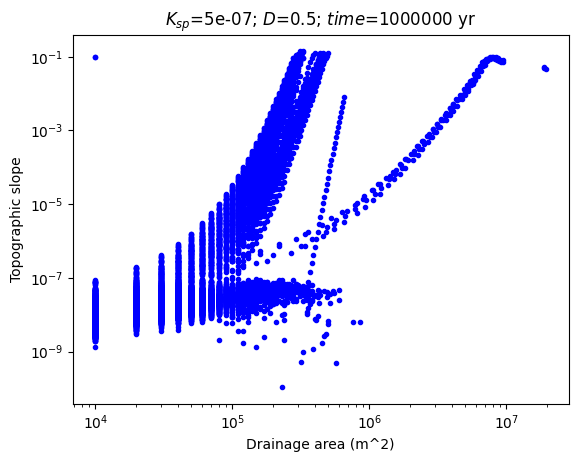

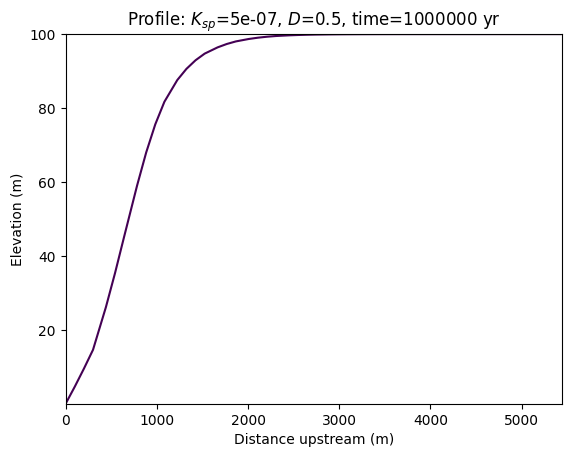

Diffusivity used: 0.5 m²/yr
Average slope: 0.0015
Total relief: 100.00 m
Mean channel steepness index: 0.00
Critical drainage area is 8370000.0 m2


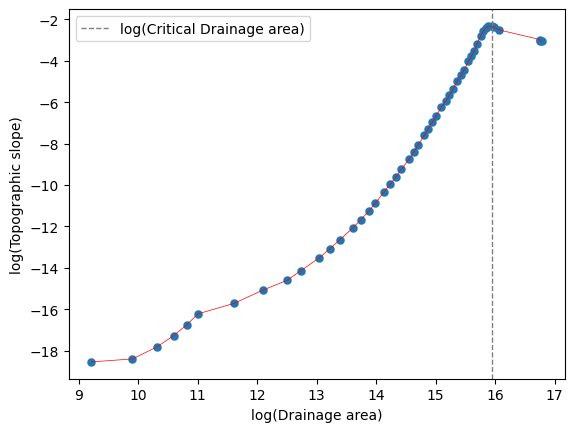

(RasterModelGrid((120, 120), xy_spacing=(np.float64(100.0), np.float64(100.0)), xy_of_lower_left=(np.float64(0.0), np.float64(0.0))),
 <landlab.components.profiler.channel_profiler.ChannelProfiler at 0x20bf361dde0>)

In [22]:
wrapper(K_sp=5e-7,D=0.5)

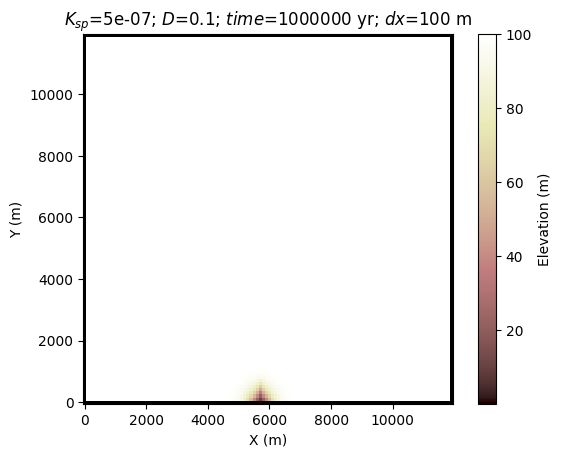

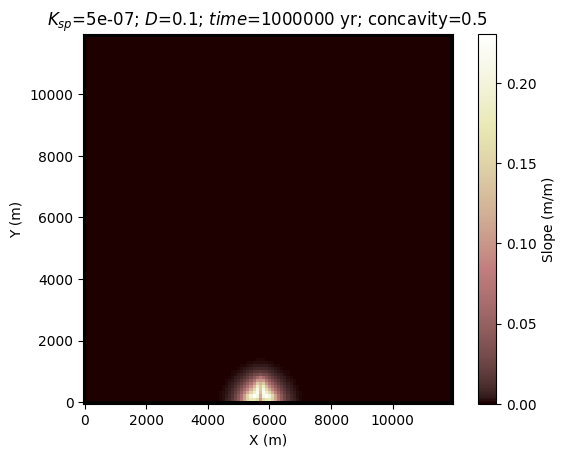

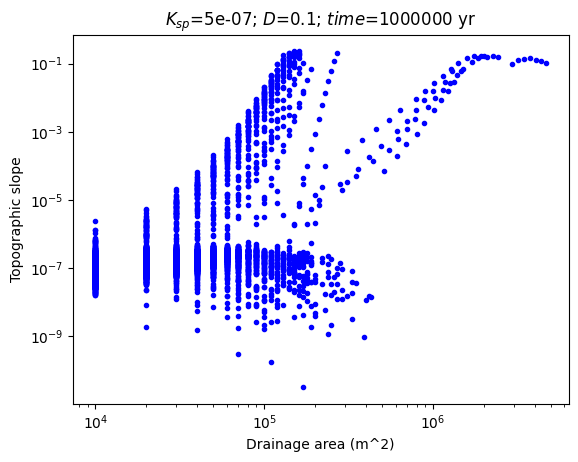

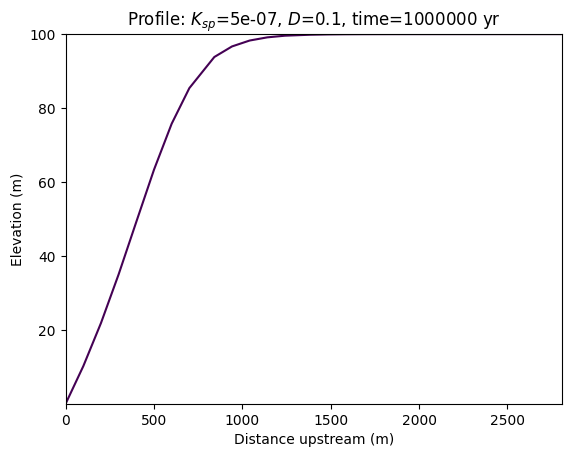

Diffusivity used: 0.1 m²/yr
Average slope: 0.0008
Total relief: 100.00 m
Mean channel steepness index: 0.00
Critical drainage area is 3760000.0 m2


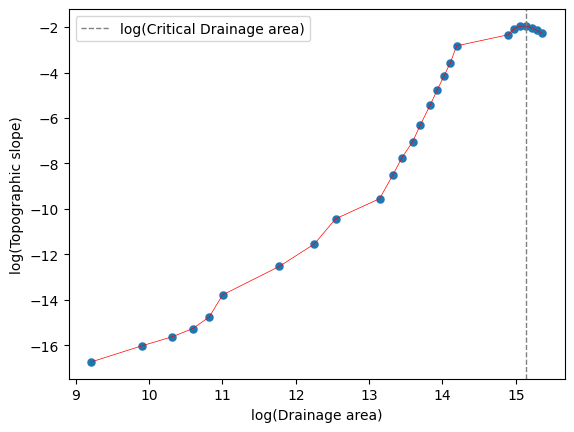

(RasterModelGrid((120, 120), xy_spacing=(np.float64(100.0), np.float64(100.0)), xy_of_lower_left=(np.float64(0.0), np.float64(0.0))),
 <landlab.components.profiler.channel_profiler.ChannelProfiler at 0x20bf64f8730>)

In [23]:
wrapper(K_sp=5e-7,D=0.1)

5. You should have produced a total of 9 steady-state landscapes, using three different fluvial erodibility values, and at least three different diffusivity values. In all cases, the uplift rate remained the same, so the erosion rate remained the same. What trends do you notice about controls on relief, average slope, and channel steepness index? Is relief related to critical drainage area? Is it related to channel steepness index? Average slope? Can you summarize (in 5 sentences or less) some things you have learned about rivers and fluvial erodbility, hillslopes and diffusivity, and topographic trends? (15 pts)

6. Thought question ... If you had a larger watershed, do you think that would impact any of the trends (or lack of trends) that you observed? Please explain in 5 sentences or less. (5 pts)


#### Q5
---

#### Landscape Evolution Analysis

Across the 9 steady-state landscapes you generated, the **uplift rate was held constant**, so **erosion had to balance uplift** to maintain equilibrium. The main variables altered were:

- **Fluvial erodibility** (\(K_{sp}\))  
- **Diffusivity** (D)  

These control how efficiently rivers and hillslopes, respectively, can transport material. By comparing results across these combinations, several clear patterns emerge:

---

#### 1. Relief and Channel Steepness Index (ksn)

**Relief** and **ksn** are most sensitive to **fluvial erodibility** (\(K_{sp}\)):

- Lower \(K_{sp}\) → **higher ksn and greater relief**  
  - Channels must be steeper to maintain erosion with less efficient river incision.

**Examples:**

- **Run 6** (\(K_{sp} = 5 \times 10^{-7}, D = 0.1\))  
  → One of the **highest ksn values** and **greatest relief**.
  
- **Run 1** (\(K_{sp} = 1 \times 10^{-6}, D = 0.1\))  
  → Also high relief, but **slightly lower than Run 6** due to higher \(K_{sp}\).  

> This indicates both low **diffusivity** and low \(K_{sp}\) contribute to increased steepness and roughness, but **\(K_{sp}\)** plays a **dominant role** in channel steepness.

---

#### 2. Average Slope and Hillslope Processes

**Diffusivity (D)** controls **hillslope gradient and smoothness**:

- **Higher D** → gentler hillslopes, **lower average slope**
  - *E.g., Run 3 (D = 1.0)*

- **Lower D** → steeper slopes, **rougher landscapes**
  - *E.g., Run 1 (D = 0.1)*

- **Run 4** (\(K_{sp} = 5 \times 10^{-7}, D = 1.0\))  
  → Despite low \(K_{sp}\), the **high diffusivity led to one of the flattest landscapes**.  
  → Demonstrates how **dominant D can be** in controlling slope gradients.

---

#### 3. Balance Between River and Hillslope Processes

Some runs, like **Run 2** and **Run 5**, show more **balanced outcomes**—neither extremely rough nor flat.

- **Intermediate \(K_{sp}\) and D values** → more **realistic and stable topographies**
- These runs may better represent **natural landscapes**, where **both rivers and hillslopes** shape terrain.

---

#### Summary of Trends

- **Relief** correlates strongly with **channel steepness index (ksn)**  
  → Both **increase with decreasing fluvial erodibility**

- Relief is **less tied to critical drainage area**, which mostly affects channel network structure rather than vertical relief.

- **Average slope** is **most sensitive to diffusivity**  
  → High D = low average slope  
  → Low D = high average slope

---

#### Key Takeaways

- **Rivers (fluvial processes)** dominate **vertical incision** and control **relief** via \(K_{sp}\) and **ksn**.
- **Hillslopes (diffusive processes)** smooth out topography and control **slope** via D.
- **Low \(K_{sp}\)** + **Low D** → **most rugged, high-relief** landscapes with **steep channels and hillslopes**.
- **High \(K_{sp}\)** or **High D** → **flatter, smoother** landscapes with reduced slope and relief.
- The **interplay** of these parameters determines whether a landscape becomes **sharp and mountainous** or **gentle and rolling**—even under the **same uplift conditions**.

---


#### Que 6
#### Additional Consideration: Watershed Size

Yes, a **larger watershed** could influence the trends observed:

- More area = **increased discharge**, enhancing river erosion **even with the same \(K_{sp}\)**.
- Could lead to **lower ksn**, **reduced relief**, and **smoother landscapes**.
- **Critical drainage area thresholds** might be crossed more frequently:
  - Affects **channel network development** and **incision patterns**.
- **Watershed size** can amplify or dampen erosional efficiency, subtly shifting the balance between **fluvial incision** and **hillslope diffusion**.

---